## Supervised Learning Practice (Logistic Regression and XGBoost)

<a target="_blank" href="https://colab.research.google.com/github/ITU-AI-ML-in-5G-Challenge/MentoringSessions2022/blob/main/ML_model_building_and_training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Radio Link Failure Prediction Dataset

Basline model from: https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/blob/main/RLF_Prediction_ITU_AIML_Challenge_Data/TurkcellExampleProject.ipynb

### Downloading Data

In [140]:
#Downloading the data from github (uncomment to download)
#The RegionA.zip should already be in the data folder. If you can not find it, you should be able to retrieve it using the codes below.
!wget -nc https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/raw/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Data.7z
!7z x RLF_Prediction_ITU_AIML_Challenge_Data.7z -aos RLF_Prediction_ITU_AIML_Challenge_Data/RegionA.zip
#You may need to manually decompress RLF_Prediction_ITU_AIML_Challenge_Data.7z

### Libraries

In [141]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing

In [142]:
#data_zip_path = "RLF_Prediction_ITU_AIML_Challenge_Data/RegionA.zip" this is the original
data_zip_path = "data/RegionA.zip" #this is the original

In [143]:
# Zip file reading
def read_table_from_zip(zip_path, table_name):
    with ZipFile(zip_path) as zip_file:
        with zip_file.open(table_name) as file:
            df = pd.read_csv(file, sep="\t", index_col=0)
            if "datetime" in df:
                df["datetime"] = pd.to_datetime(df["datetime"])
            return df

In [144]:
# Example read for RL-KPIS
df = read_table_from_zip(data_zip_path, "rl-kpis.tsv")
print(f"rl_kpis.shape: {df.shape}")
print(df.datetime.min(), df.datetime.max())

rl_kpis.shape: (1992986, 18)
2018-12-31 00:00:00 2020-12-25 00:00:00


In [145]:
df.head(10)

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
5,ENK,2018-12-31,FAR,A9ZA,"1,344,254",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-38.2,456.0,1024QAM,False
6,ENK,2018-12-31,NEAR,A0EB,"1,349,988",RL_;ABL>,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-33.2,456.0,1024QAM,False
7,ENK,2018-12-31,NEAR,A0IB,"1,349,988",RL_;ABL>,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-31.0,456.0,1024QAM,False
8,ENK,2018-12-31,FAR,A9AM,"1,371,838",RL_;ABL>,cardtype4,Enable,f5,0.0,0.0,0.0,18.0,0.0,-29.7,81.0,256QAM,False
9,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False


In [146]:
df.rlf.value_counts()

False    1991767
True        1219
Name: rlf, dtype: int64

In [147]:
df_labels = df[["datetime", "site_id", "mlid"]]
df_labels.head()

,datetime,site_id,mlid
0,2018-12-31,RL_;ABDV,A0BE
1,2018-12-31,RL_;ABDV,A0BI
2,2018-12-31,RL_;ABDV,A5AB
3,2018-12-31,RL_;ABDV,A8CQ
4,2018-12-31,RL_;ABDV,A8DQ


In [148]:
prediction_interval = 5

for i in range(prediction_interval):
  df_labels[f"T+{i+1}"] = df_labels["datetime"] + pd.DateOffset(days=i+1)
df_labels.head()

/tmp/ipykernel_848/3134115453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels[f"T+{i+1}"] = df_labels["datetime"] + pd.DateOffset(days=i+1)


,datetime,site_id,mlid,T+1,T+2,T+3,T+4,T+5
0,2018-12-31,RL_;ABDV,A0BE,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
1,2018-12-31,RL_;ABDV,A0BI,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
2,2018-12-31,RL_;ABDV,A5AB,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
3,2018-12-31,RL_;ABDV,A8CQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
4,2018-12-31,RL_;ABDV,A8DQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05


In [149]:
temp = df[["datetime", "site_id", "mlid", "rlf"]] #resolved
for i in range(prediction_interval):
  target_day_column_name = f"T+{i+1}"
  df_labels = df_labels.merge(temp, 
                  how = "left", 
                  left_on = ("site_id", "mlid", target_day_column_name),
                  right_on = ("site_id", "mlid", "datetime"),
                  suffixes = ("", "_y") #question here(to delete just the new columns of datetime)
  )
  df_labels.rename(columns={"rlf": f"{target_day_column_name}_rlf"}, inplace=True)
  #print(df_labels.head(5))
df_labels.drop(columns=["datetime_y"], inplace=True)
df_labels.head()

,datetime,site_id,mlid,T+1,T+2,T+3,T+4,T+5,T+1_rlf,T+2_rlf,T+3_rlf,T+4_rlf,T+5_rlf
0,2018-12-31,RL_;ABDV,A0BE,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
1,2018-12-31,RL_;ABDV,A0BI,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
2,2018-12-31,RL_;ABDV,A5AB,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
3,2018-12-31,RL_;ABDV,A8CQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
4,2018-12-31,RL_;ABDV,A8DQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False


In [150]:
df_labels["1-day-predict"] = df_labels["T+1_rlf"]

In [151]:
following_days_rlf_columns = []
for x in range(prediction_interval):
    following_days_rlf_columns.append(f"T+{i+1}_rlf")

In [152]:
df_labels["5-day-predict"] = df_labels[following_days_rlf_columns].any(axis=1)
#.any() adds True if there is any True values

In [153]:
df_labels = df_labels[["datetime", "site_id", "mlid", "1-day-predict", "5-day-predict"]]

In [154]:
df_clean = df.merge(df_labels, 
                    how="left", 
                    on=["datetime", "site_id", "mlid"])

In [155]:
df_clean

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False,False,False
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False,False,False
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False,False,False
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,NEC,2020-12-25,NEAR,A6FD,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,NaN,False
1992982,NEC,2020-12-25,NEAR,A6NA,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,NaN,False
1992983,NEC,2020-12-25,FAR,A8FJ,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,NaN,False
1992984,NEC,2020-12-25,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,NaN,False


In [156]:
df_num = df_clean[['severaly_error_second','error_second','error_second','unavail_second','avail_time','bbe','rxlevmax','capacity','rlf','1-day-predict','5-day-predict']]

In [157]:
df_num

,severaly_error_second,error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf,1-day-predict,5-day-predict
0,0.0,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,False,False,False
1,0.0,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,False,False,False
2,0.0,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,False,False,False
3,0.0,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,False,False,False
4,0.0,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1992981,0.0,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,False,NaN,False
1992982,0.0,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,False,NaN,False
1992983,0.0,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,False,NaN,False
1992984,0.0,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,False,NaN,False


In [158]:
clean_df_num = pd.get_dummies(data=df_num, columns=['rlf','1-day-predict','5-day-predict'])

In [159]:
clean_df_num.drop(columns=['rlf_False','1-day-predict_False','5-day-predict_False'], inplace=True)

In [160]:
clean_df_num.head(10)

,severaly_error_second,error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf_True,1-day-predict_True,5-day-predict_True
0,0.0,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,0,0,0
1,0.0,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,0,0,0
2,0.0,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,0,0,0
3,0.0,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,0,0,0
4,0.0,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,0,0,0
5,0.0,0.0,0.0,0.0,86.4,0.0,-38.2,456.0,0,0,0
6,0.0,0.0,0.0,0.0,18.0,0.0,-33.2,456.0,0,0,0
7,0.0,0.0,0.0,0.0,18.0,0.0,-31.0,456.0,0,0,0
8,0.0,0.0,0.0,0.0,18.0,0.0,-29.7,81.0,0,0,0
9,0.0,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,0,0,0


In [161]:
clean_df_num = clean_df_num.dropna()

In [162]:
clean_df_num

,severaly_error_second,error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf_True,1-day-predict_True,5-day-predict_True
0,0.0,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,0,0,0
1,0.0,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,0,0,0
2,0.0,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,0,0,0
3,0.0,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,0,0,0
4,0.0,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1992981,0.0,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,0,0,0
1992982,0.0,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,0,0,0
1992983,0.0,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,0,0,0
1992984,0.0,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,0,0,0


In [163]:
sample_df = clean_df_num.sample(frac=0.1)
sample_df.reset_index()

,index,severaly_error_second,error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf_True,1-day-predict_True,5-day-predict_True
0,1702878,0.0,0.0,0.0,0.0,86.4,0.0,-40.1,406.0,0,0,0
1,1004676,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,81.0,0,0,0
2,1429811,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,325.0,0,0,0
3,732077,0.0,0.0,0.0,0.0,86.4,0.0,-39.8,203.0,0,0,0
4,1468968,0.0,0.0,0.0,0.0,86.4,0.0,-37.4,247.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
199277,1247898,0.0,0.0,0.0,0.0,86.4,0.0,-40.1,456.0,0,0,0
199278,1652973,0.0,2.0,2.0,0.0,86.4,4.0,-39.5,406.0,0,0,0
199279,1611265,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,406.0,0,0,0
199280,1558490,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,203.0,0,0,0


In [164]:
sample_df

,severaly_error_second,error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf_True,1-day-predict_True,5-day-predict_True
1702878,0.0,0.0,0.0,0.0,86.4,0.0,-40.1,406.0,0,0,0
1004676,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,81.0,0,0,0
1429811,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,325.0,0,0,0
732077,0.0,0.0,0.0,0.0,86.4,0.0,-39.8,203.0,0,0,0
1468968,0.0,0.0,0.0,0.0,86.4,0.0,-37.4,247.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1247898,0.0,0.0,0.0,0.0,86.4,0.0,-40.1,456.0,0,0,0
1652973,0.0,2.0,2.0,0.0,86.4,4.0,-39.5,406.0,0,0,0
1611265,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,406.0,0,0,0
1558490,0.0,0.0,0.0,0.0,86.4,0.0,-39.5,203.0,0,0,0


In [165]:
X = sample_df.drop(columns=['1-day-predict_True','5-day-predict_True'])

In [166]:
#y_1 = clean_df_num['1-day-predict_True']

In [167]:
y = sample_df['5-day-predict_True']

In [168]:
from sklearn.model_selection import train_test_split

In [169]:
from sklearn.preprocessing import StandardScaler

In [170]:
#just a test
X.drop(columns=['rlf_True'],axis=1,inplace=True)
y.drop(columns=['rlf_True'],axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [172]:
scaler = StandardScaler()

In [173]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression

In [175]:
model_lr =LogisticRegression()

In [177]:
model_lr.fit(scaled_X_train, y_train)

LogisticRegression()

In [178]:
model_lr.score(scaled_X_test,y_test)

0.9994525880420899

In [179]:
model_lr.score(scaled_X_test,y_test)

0.9994525880420899

In [180]:
from sklearn.metrics import classification_report

In [181]:
predictions_lr = model_lr.predict(scaled_X_test)

In [182]:
print(classification_report(y_test, predictions_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65730
           1       0.00      0.00      0.00        34

    accuracy                           1.00     65764
   macro avg       0.50      0.50      0.50     65764
weighted avg       1.00      1.00      1.00     65764



## Logistic Regression (Part Two: Building your own model from scratch)

In [183]:
from numpy import log, dot, e
from numpy.random import rand
import math

Text(0, 0.5, 'Y = Sigmoid x')

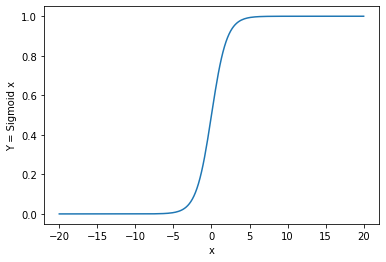

In [184]:
x = np.linspace(-20, 20, 200) #numbers from -20 to 20, generated 200 numbers
y = 1 / (1 + e**(-x))
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("Y = Sigmoid x")

In [200]:
class LogisticRegression():
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    def cost_function(self, X,y,weights):
        epsilon = 1e-5 
        z = dot(X,weights) #matrix calculation
        a1 = y*log(self.sigmoid(z))
        a2 = (1-y)*log(1-self.sigmoid(z)+epsilon)
        return -sum(a1+a2)/len(X) #logistic regression uses log loss function
    def fit(self, X, y, epochs=500, lr = 0.05): # w = w-gradient*alpha=lr
        loss = []
        weights = rand(X.shape[1]) #gives us length of columns
        n = len(X) #gives us length of rows
        for x in range(epochs):
            #Gradient Descent
            y_hat = self.sigmoid(dot(X,weights))
            weights -= lr*dot(X.T, y_hat-y)/n
            loss.append(self.cost_function(X,y,weights))
        plt.plot(range(0,epochs),loss,label='Loss')
        print(range(1,epochs+1))
        plt.ylabel('Loss')
        plt.xlabel("Epochs")
        self.weights = weights
        self.loss = loss
    def predict(self,X):
        z = dot(X, self.weights)
        ans = []
        for i in self.sigmoid(z):
            if i>0.5:
                ans.append(1)
            else:
                ans.append(0)
        return ans

In [201]:
model = LogisticRegression()

range(1, 501)


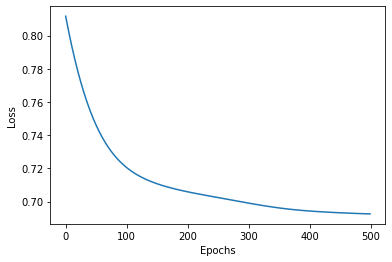

In [202]:
model.fit(scaled_X_train,y_train)

In [203]:
predictions = model.predict(scaled_X_test)

In [204]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     65730
           1       0.00      0.09      0.00        34

    accuracy                           0.98     65764
   macro avg       0.50      0.53      0.50     65764
weighted avg       1.00      0.98      0.99     65764



## XGBoost

In [207]:
from xgboost import XGBClassifier

In [209]:
model = XGBClassifier(n_estimators=200)

In [210]:
evalset =[(scaled_X_train,y_train),(scaled_X_test,y_test)]

In [212]:
model.fit(scaled_X_train,y_train, eval_metric='logloss',eval_set=evalset)

[0]	validation_0-logloss:0.43802	validation_1-logloss:0.43804
[1]	validation_0-logloss:0.29713	validation_1-logloss:0.29715
[2]	validation_0-logloss:0.20836	validation_1-logloss:0.20842
[3]	validation_0-logloss:0.14905	validation_1-logloss:0.14910
[4]	validation_0-logloss:0.10804	validation_1-logloss:0.10811
[5]	validation_0-logloss:0.07910	validation_1-logloss:0.07919
[6]	validation_0-logloss:0.05839	validation_1-logloss:0.05851
[7]	validation_0-logloss:0.04346	validation_1-logloss:0.04358
[8]	validation_0-logloss:0.03263	validation_1-logloss:0.03276
[9]	validation_0-logloss:0.02474	validation_1-logloss:0.02489
[10]	validation_0-logloss:0.01899	validation_1-logloss:0.01914
[11]	validation_0-logloss:0.01479	validation_1-logloss:0.01495
[12]	validation_0-logloss:0.01173	validation_1-logloss:0.01190
[13]	validation_0-logloss:0.00949	validation_1-logloss:0.00968
[14]	validation_0-logloss:0.00788	validation_1-logloss:0.00808


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-logloss:0.00670	validation_1-logloss:0.00693
[16]	validation_0-logloss:0.00585	validation_1-logloss:0.00610
[17]	validation_0-logloss:0.00524	validation_1-logloss:0.00552
[18]	validation_0-logloss:0.00480	validation_1-logloss:0.00511
[19]	validation_0-logloss:0.00447	validation_1-logloss:0.00482
[20]	validation_0-logloss:0.00424	validation_1-logloss:0.00462
[21]	validation_0-logloss:0.00406	validation_1-logloss:0.00449
[22]	validation_0-logloss:0.00393	validation_1-logloss:0.00440
[23]	validation_0-logloss:0.00384	validation_1-logloss:0.00435
[24]	validation_0-logloss:0.00376	validation_1-logloss:0.00431
[25]	validation_0-logloss:0.00371	validation_1-logloss:0.00429
[26]	validation_0-logloss:0.00367	validation_1-logloss:0.00429
[27]	validation_0-logloss:0.00364	validation_1-logloss:0.00429
[28]	validation_0-logloss:0.00361	validation_1-logloss:0.00430
[29]	validation_0-logloss:0.00357	validation_1-logloss:0.00431
[30]	validation_0-logloss:0.00355	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=14,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [213]:
from sklearn.metrics import accuracy_score

# evaluate performance
yhat = model.predict(scaled_X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.999


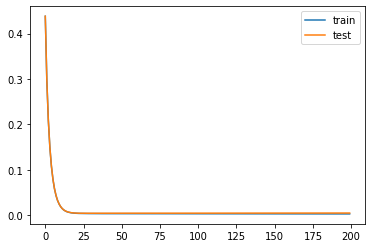

In [214]:
from matplotlib import pyplot

# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [215]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65730
           1       0.00      0.00      0.00        34

    accuracy                           1.00     65764
   macro avg       0.50      0.50      0.50     65764
weighted avg       1.00      1.00      1.00     65764



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
